In [ ]:
!df -h

Filesystem      Size  Used Avail Use% Mounted on
overlay         236G   33G  204G  14% /
tmpfs            64M     0   64M   0% /dev
shm              41G     0   41G   0% /dev/shm
/dev/root       2.0G  1.2G  820M  59% /usr/sbin/docker-init
tmpfs            42G   80K   42G   1% /var/colab
/dev/sda1       242G   35G  208G  15% /kaggle/input
tmpfs            42G     0   42G   0% /proc/acpi
tmpfs            42G     0   42G   0% /proc/scsi
tmpfs            42G     0   42G   0% /sys/firmware


In [ ]:
import os
from tqdm import tqdm

import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.utils import *
import tensorflow as tf


In [ ]:
import kagglehub

data_download_path = kagglehub.dataset_download("tusharchauhan1898/comofod")

print("Path to dataset files:", data_download_path)

100%|██████████| 2.99G/2.99G [00:22<00:00, 146MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tusharchauhan1898/comofod/versions/1


In [ ]:
images = os.listdir("/root/.cache/kagglehub/datasets/tusharchauhan1898/comofod/versions/1/CoMoFoD_small_v2/")
print("Total image found: {}".format(len(images)))

Total image found: 10402


In [ ]:
os.makedirs("dataset/labels", exist_ok=True)
os.makedirs("dataset/images", exist_ok=True)
os.makedirs("dataset/masks", exist_ok=True)

In [ ]:
for image in tqdm(images):
    if len(image.split("_")) == 2:
        if "B" in image:
            os.system("cp /root/.cache/kagglehub/datasets/tusharchauhan1898/comofod/versions/1/CoMoFoD_small_v2/{} ./dataset/labels/".format(image))
    if len(image.split("_")) == 2:
        if "M" in image:
            os.system("cp /root/.cache/kagglehub/datasets/tusharchauhan1898/comofod/versions/1/CoMoFoD_small_v2/{} ./dataset/masks/".format(image))
    if len(image.split("_")) > 2:
        if "F" in image:
            os.system("cp /root/.cache/kagglehub/datasets/tusharchauhan1898/comofod/versions/1/CoMoFoD_small_v2/{} ./dataset/images/".format(image))
    if len(image.split("_")) > 2:
        if "O" in image:
            os.system("cp /root/.cache/kagglehub/datasets/tusharchauhan1898/comofod/versions/1/CoMoFoD_small_v2/{} ./dataset/images/".format(image))

100%|██████████| 10402/10402 [00:24<00:00, 427.21it/s]


In [ ]:
print("Total Labels: ", len(os.listdir("dataset/labels/")))
print("Total Masks: ", len(os.listdir("dataset/masks/")))
print("Total Forged Images: ", len(os.listdir("dataset/images/")))

Total Labels:  200
Total Masks:  200
Total Forged Images:  9600


In [ ]:
def unet(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    conv1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = BatchNormalization()(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = BatchNormalization()(conv5)

    conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    conv5 = BatchNormalization()(conv5)

    up6 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv5))
    up6 = BatchNormalization()(up6)
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv6))
    up7 = BatchNormalization()(up7)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = Conv2D(32, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv7))
    up8 = BatchNormalization()(up8)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = BatchNormalization()(conv8)


    up9 = Conv2D(16, 2, activation='relu', padding='same', kernel_initializer='he_normal')(
        UpSampling2D(size=(2, 2))(conv8))
    up9 = BatchNormalization()(up9)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = BatchNormalization()(conv9)
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    return model

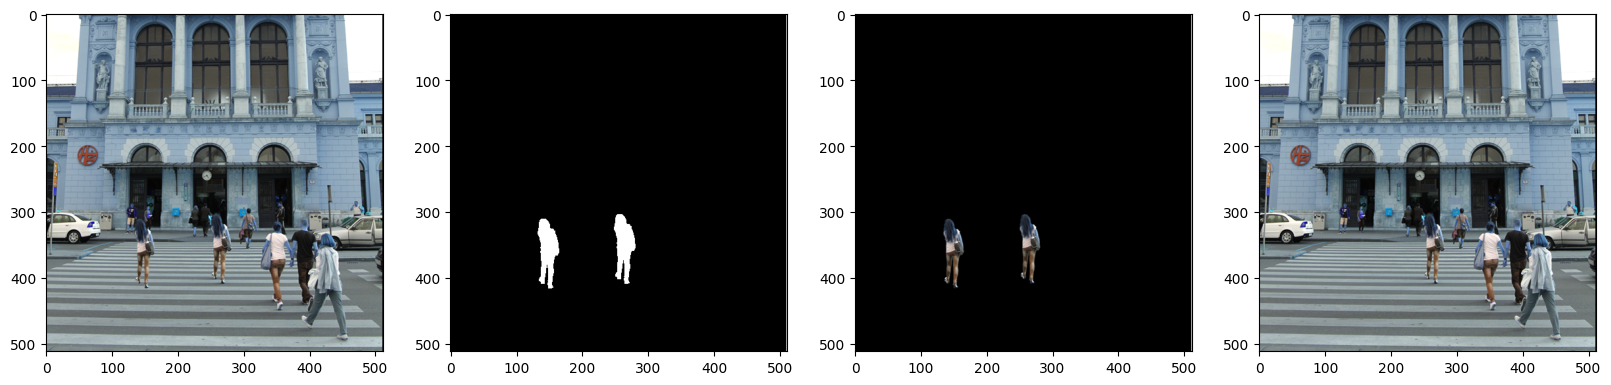

In [ ]:
image = cv2.imread("dataset/images/001_F_BC1.png", cv2.IMREAD_COLOR)
mask = cv2.imread("dataset/labels/001_B.png")
cropped_image = cv2.imread("dataset/masks/001_M.png")
auth_image = cv2.imread("dataset/images/001_O_BC1.png")
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 20))
ax1.imshow(image)
ax2.imshow(mask)
ax3.imshow(cropped_image)
ax4.imshow(auth_image)

In [ ]:
train_test_images = os.listdir("dataset/images")
train_images = train_test_images[:int(0.9 * len(train_test_images))]
test_images = train_test_images[int(0.9 * len(train_test_images)):]

print("Training Images: {}".format(len(train_images)))
print("Testing Images: {}".format(len(test_images)))

Training Images: 8640
Testing Images: 960


In [ ]:
def adjust_data(image, mask):
    image = image / 255
    mask = mask / 255

    return image, mask

def get_dct(image, block_size):
    height, width = image.shape[:2]
    w_block = int(height/block_size)
    h_block = int(width/block_size)

    gray_image = np.zeros((height, width), np.float32)
    dct_block_image = np.zeros((height, width), np.float32)

    gray_image[:height, :width] = image
    for row in range(w_block):
        for col in range(h_block):
            currunt_block = cv2.dct(gray_image[row*block_size:(row + 1)*block_size, col*block_size: (col + 1)*block_size])
            dct_block_image[row*block_size: (row + 1)*block_size, col*block_size:(col + 1)*block_size] = currunt_block

    return dct_block_image

class DataLoader(Sequence):

    def __init__(self, dataset_list,
                batch_size):
        self.dataset_list = dataset_list
        self.batch_size = batch_size
        np.random.shuffle(self.dataset_list)

    def on_epoch_end(self):
        pass

    def __len__(self):
        return len(self.dataset_list) // self.batch_size

    def __getitem__(self, index):
        i = index * self.batch_size
        batch_input_data = self.dataset_list[i : i + self.batch_size]
        x = np.zeros((self.batch_size, 256, 256, 1), dtype=np.float32)
        y = np.zeros((self.batch_size, 256, 256, 1), dtype=np.float32)
        for j, image_name in enumerate(batch_input_data):
            image = cv2.imread("dataset/images/{}".format(image_name), cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (256, 256))
            image = get_dct(image, 8)
            image = np.expand_dims(image, -1)
            if "O" not in image_name:
                mask = cv2.imread("dataset/labels/{}_B.png".format(image_name.split("_")[0]), cv2.IMREAD_GRAYSCALE)
                mask = cv2.resize(mask, (256, 256))
                mask = np.reshape(mask, (256, 256, 1))
            else:
                mask = np.zeros((256, 256, 1), dtype=np.float32)
            x[j] = image
            y[j] = mask

        return adjust_data(x,y)

In [ ]:
train_datagen = DataLoader(train_images, 128)

In [ ]:
model = unet()
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model_checkpoint = ModelCheckpoint('unet.keras', monitor="loss", verbose=1, save_best_only=True)
history = model.fit(train_datagen, epochs=40, callbacks=[model_checkpoint], verbose=1)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6015 - loss: 0.7602
Epoch 1: loss improved from inf to 0.72726, saving model to unet.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.6018 - loss: 0.7597
Epoch 2/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7531 - loss: 0.6368
Epoch 2: loss improved from 0.72726 to 0.62756, saving model to unet.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.7539 - loss: 0.6367
Epoch 3/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9191 - loss: 0.6042
Epoch 3: loss improved from 0.62756 to 0.60110, saving model to unet.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.9192 - loss: 0.6041
Epoch 4/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9571 - loss: 0.5871
Epoch 4: loss improved from 0.60110 to 0.58529, saving model to unet.keras
67/67 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.9572 - loss: 0.5871
Epoch 5/40
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9696 - loss: 0.5735
Epoch 5

In [ ]:
test_datagen = DataLoader(test_images, 8)
result = model.predict(test_datagen, verbose=0)

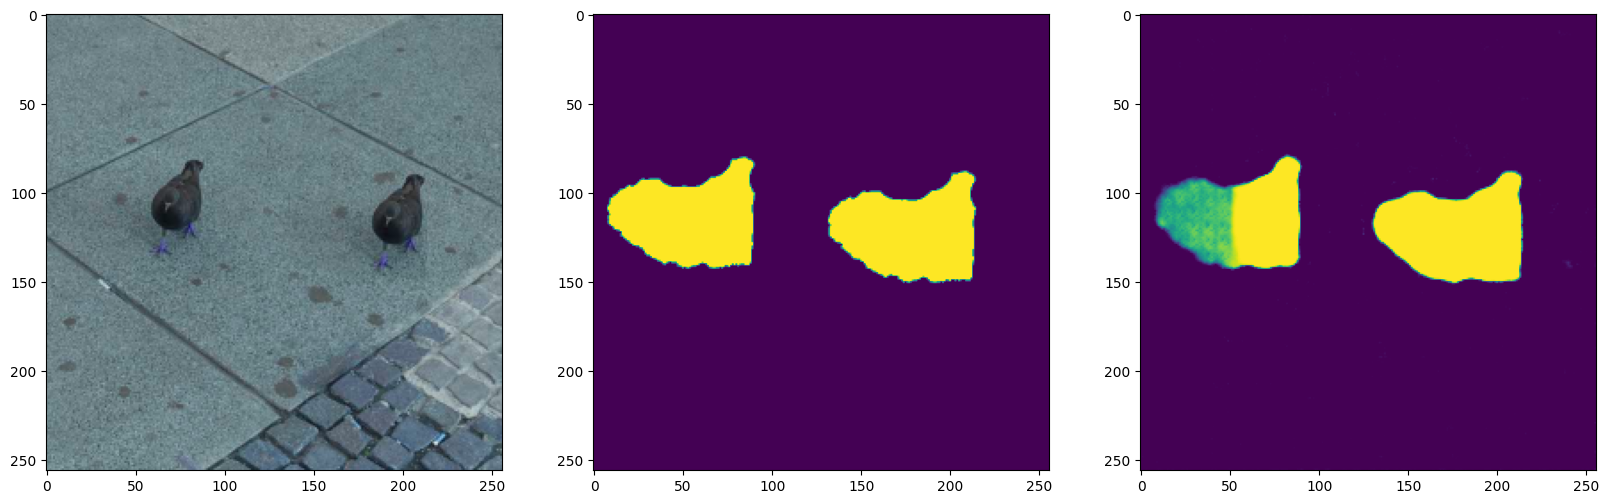

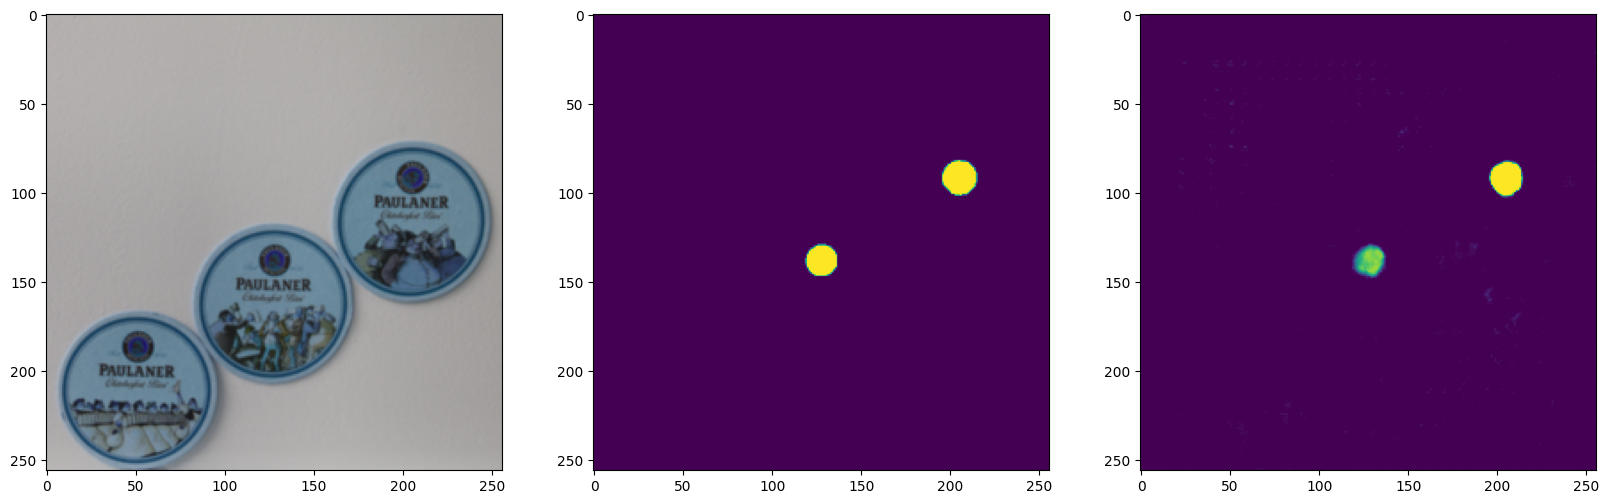

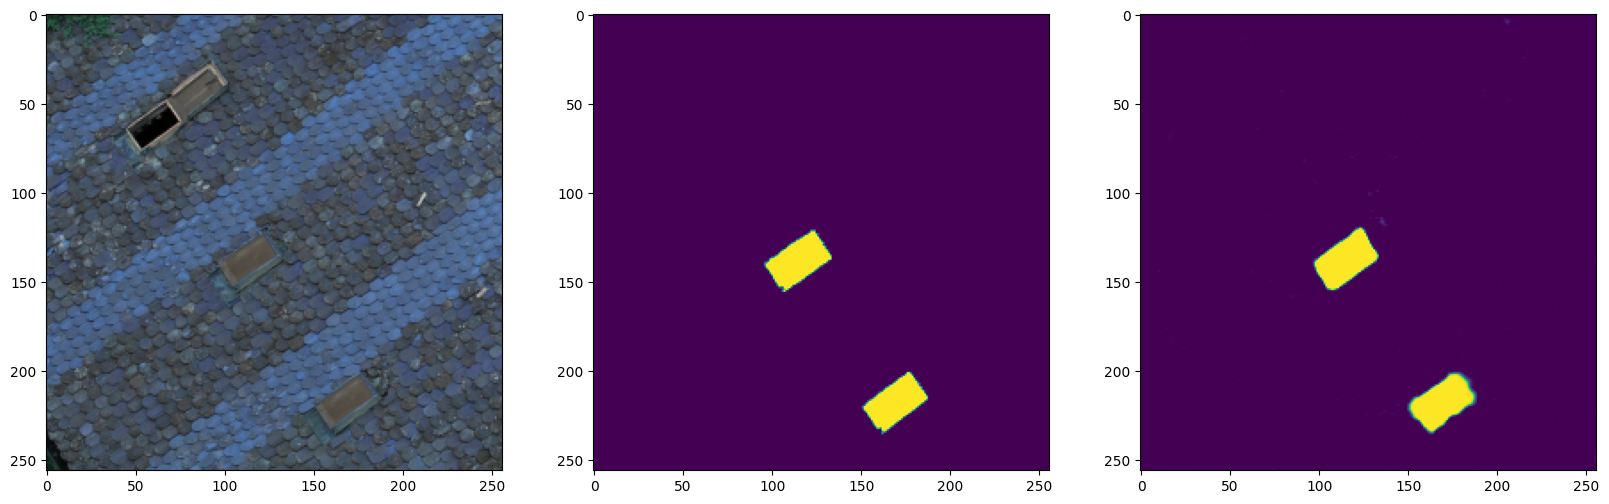

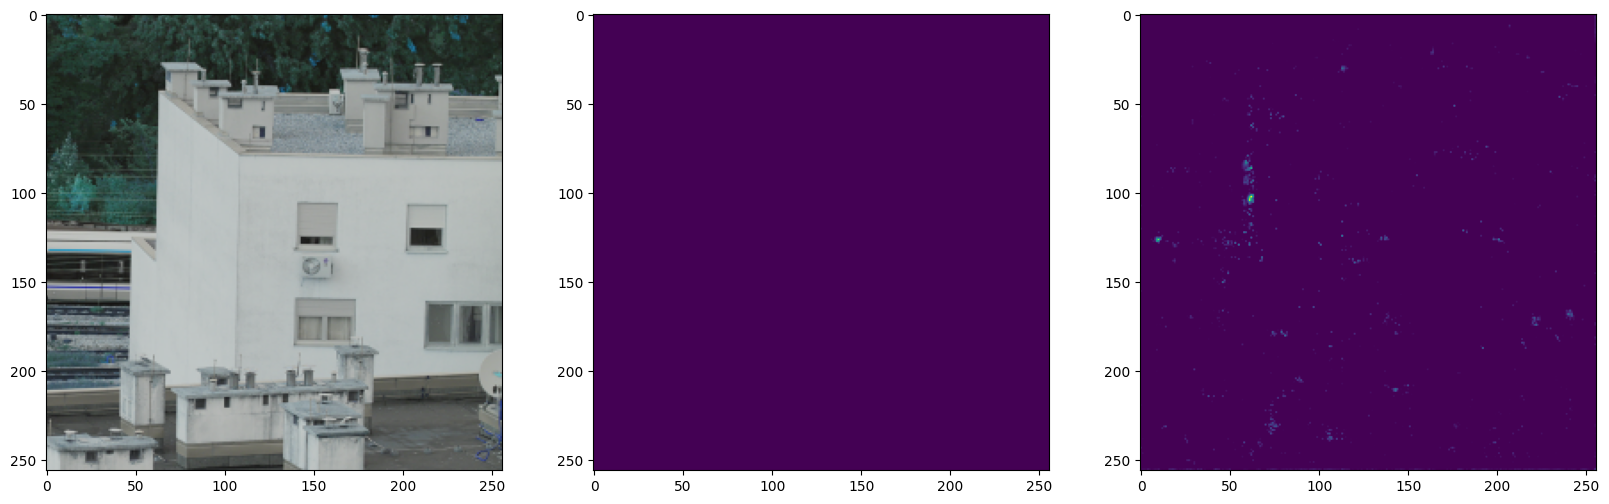

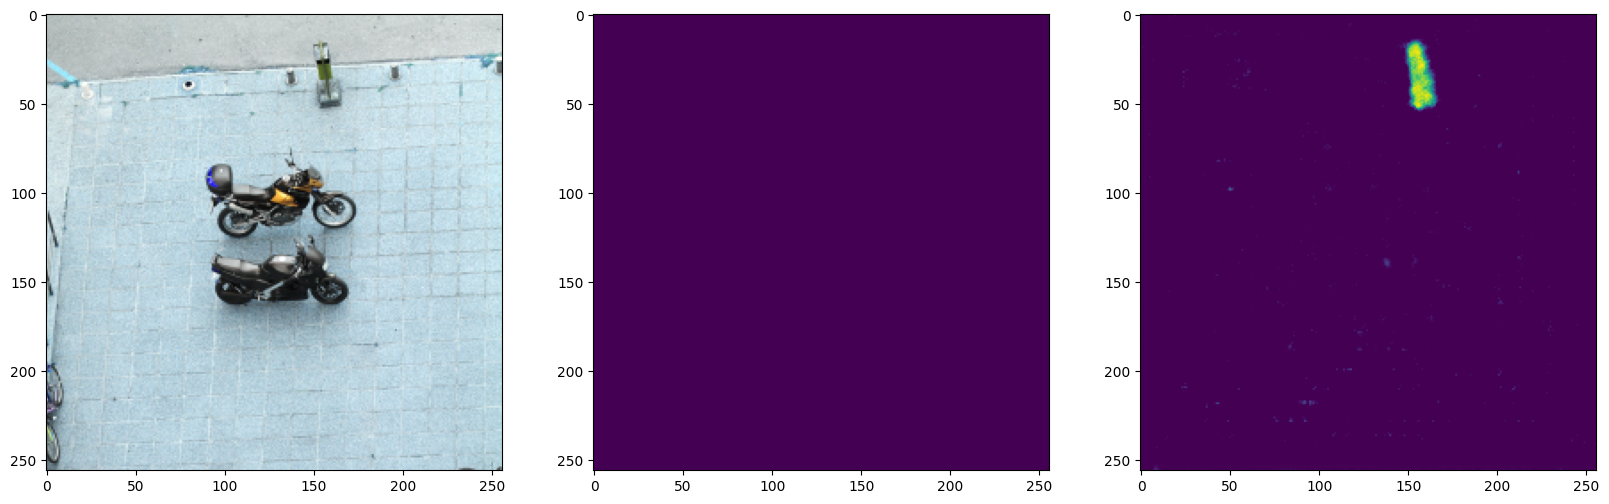

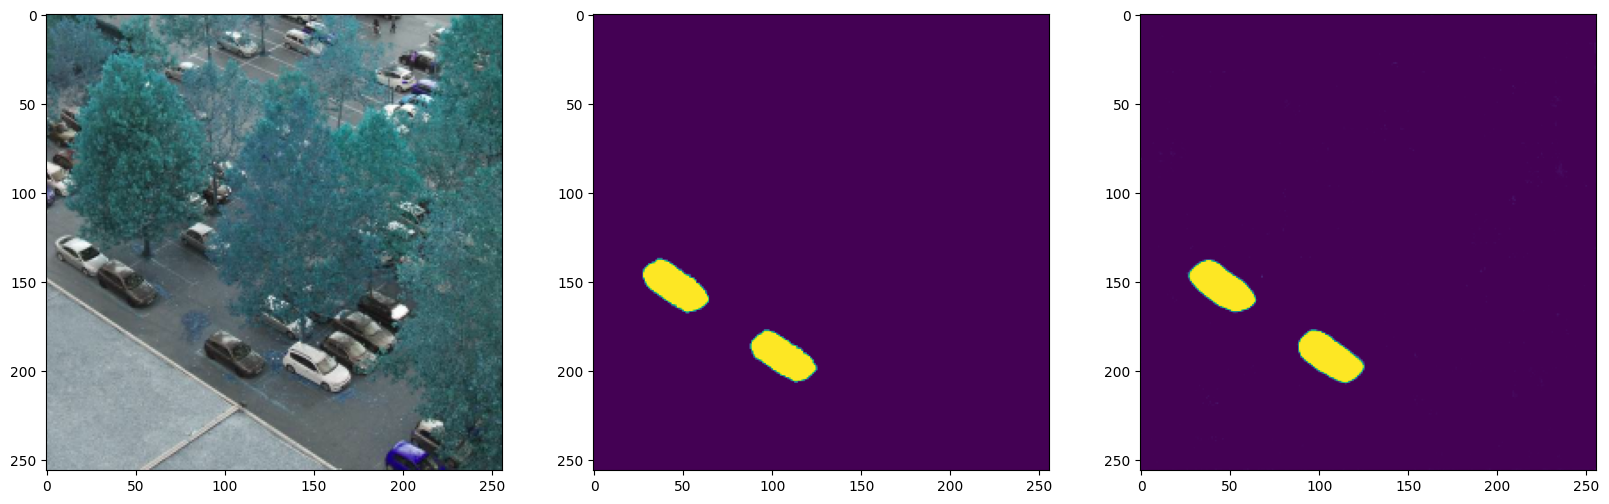

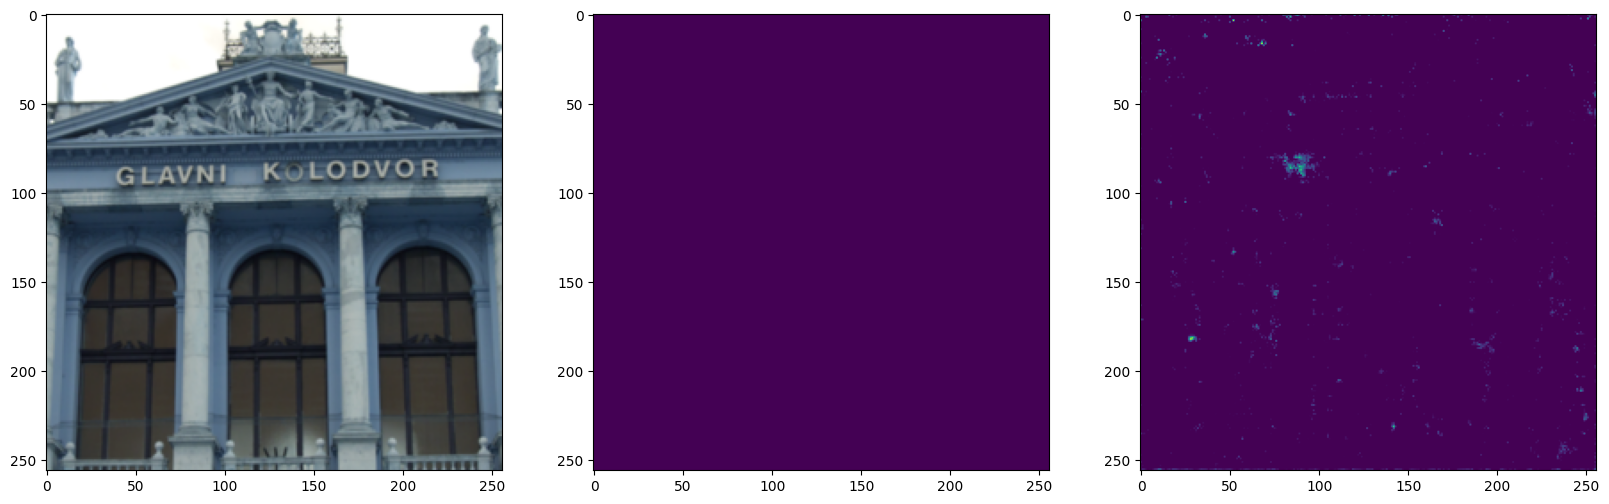

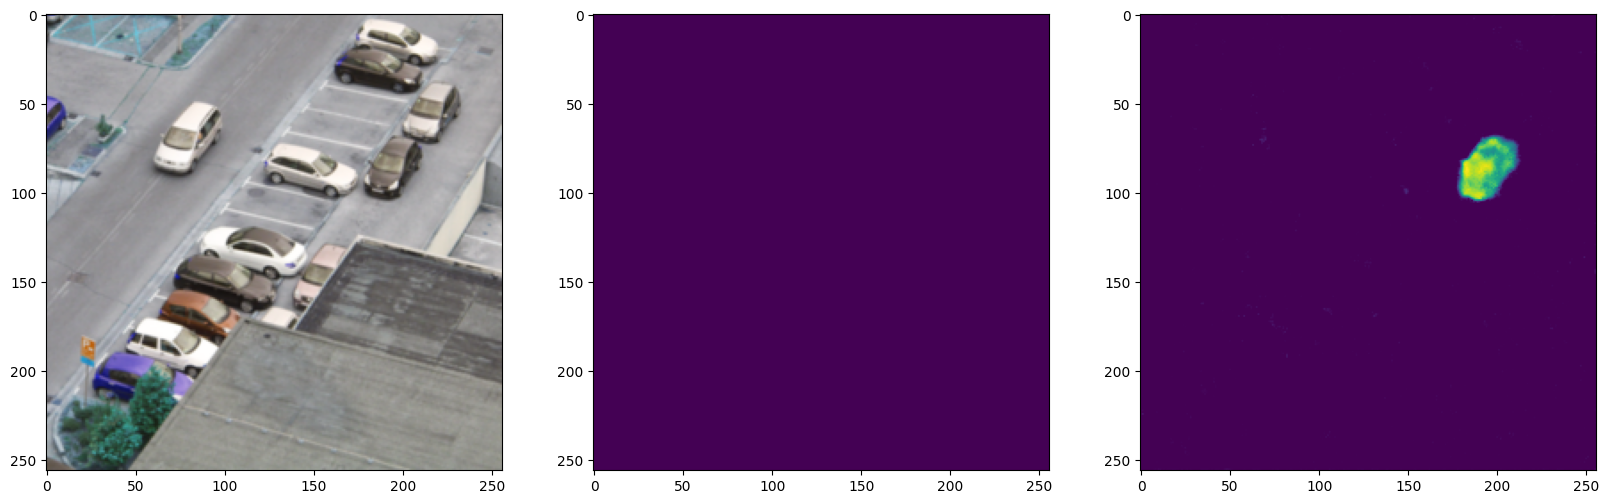

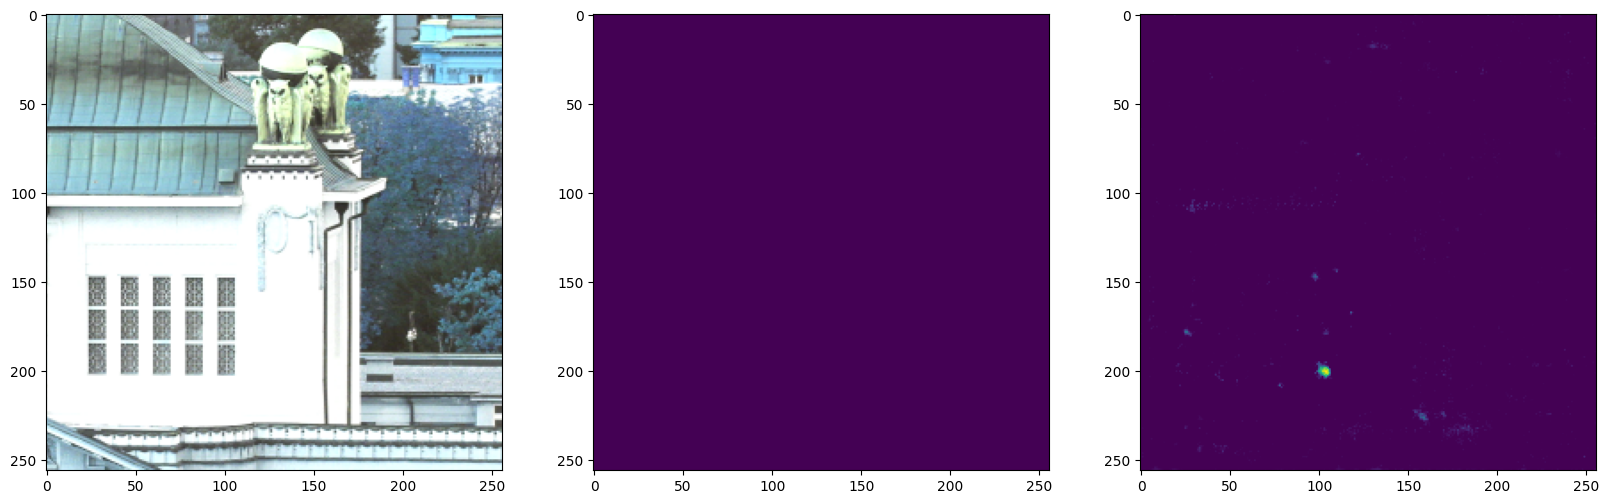

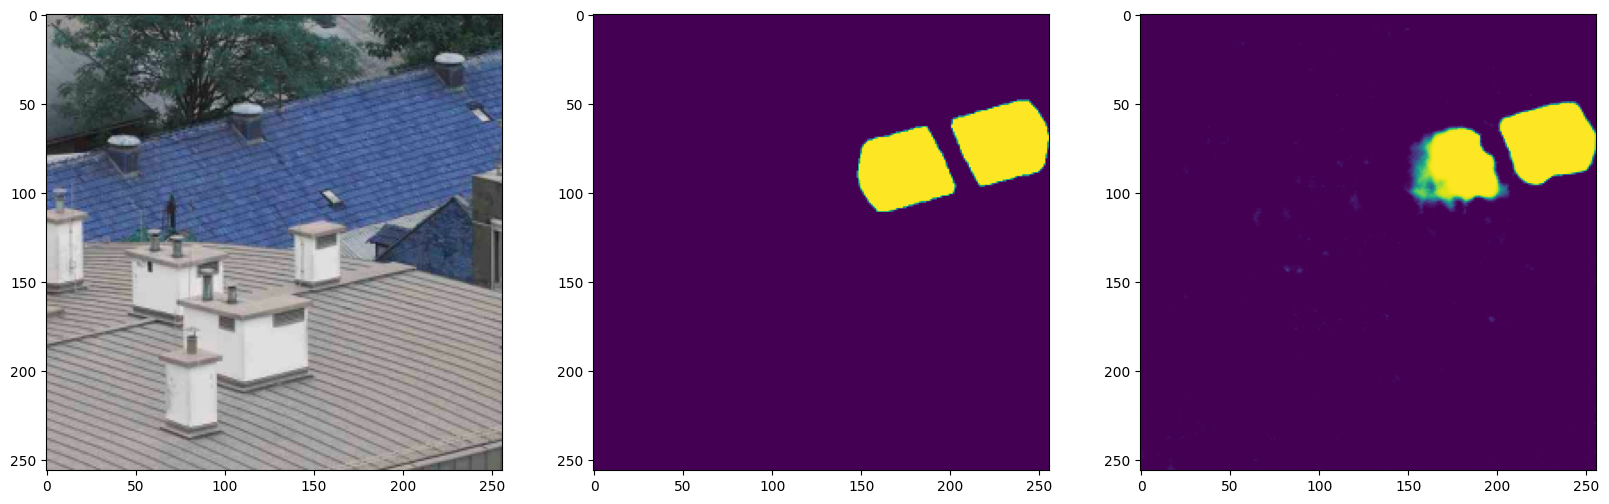

In [ ]:
for i, res in enumerate(result[50:60]):
    image_name = test_images[i + 50]
    image = cv2.imread("dataset/images/{}".format(image_name), cv2.IMREAD_COLOR)
    image = cv2.resize(image, (256, 256))
    if "O" not in image_name:
        mask = cv2.imread("dataset/labels/{}_B.png".format(image_name.split("_")[0]), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (256, 256))
    else:
        mask = np.zeros((256, 256, 1), dtype=np.float32)
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 20))
    ax1.imshow(image)
    ax2.imshow(mask)
    ax3.imshow(res)

In [ ]:
iou = []
mean_iou = 0
for i, res in enumerate(result):
    image_name = test_images[i]
    if "O" not in image_name:
        mask = cv2.imread("dataset/labels/{}_B.png".format(image_name.split("_")[0]), cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (256, 256))
    else:
        mask = np.zeros((256, 256, 1), dtype=np.float32)
    res[res>0.5] = 1
    res[res<0.5] = 0
    m = tf.keras.metrics.MeanIoU(num_classes=2)
    m.update_state(res, mask/255)
    mean_iou = mean_iou + m.result().numpy()
    iou.append(m.result().numpy())

In [ ]:
print("Accuracy of model:", mean_iou/len(result)*100)

Accuracy of model: 74.66398313020667
